In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
%matplotlib inline

In [70]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [71]:
vocab = "".join(sorted(set(x for word in names+["."] for x in word))) # building vocab

In [72]:
stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}

In [73]:
torch.set_default_device("mps")
def build_dataset(data, n_context):
    xs = []
    ys = []
    
    for x in data:
        context = [0]* n_context
        for ch in x + ".":
            # print(f"{context} {stoi[ch]}")
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:]+[ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape,ys.shape)
    return xs,ys

np.random.shuffle(names)

data_size =  len(names)
n_context = 3
train_data = names[:int(data_size * .8)]
dev_data = names[int(data_size * .8):int(data_size * .9)]
test_data = names[int(data_size * .9):]

Xtr,Ytr = build_dataset(train_data,n_context) 
Xdev,Ydev = build_dataset(dev_data,n_context)
Xtest,Ytest = build_dataset(test_data,n_context)

torch.Size([182574, 3]) torch.Size([182574])
torch.Size([22737, 3]) torch.Size([22737])
torch.Size([22835, 3]) torch.Size([22835])


In [74]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 13],
        [ 0, 13, 25],
        ...,
        [14,  1, 25],
        [ 1, 25,  1],
        [25,  1, 20]], device='mps:0')

In [75]:
e_dim = 2
h_dim = 200
g = torch.Generator(device = "mps:0").manual_seed(2147483647)
C = torch.randn(len(vocab), e_dim, generator=g) # character embeddings with dimension of 2
W1 = torch.randn(n_context*e_dim, h_dim, generator=g)
b1 = torch.randn(h_dim, generator=g)
W2 = torch.randn(h_dim,len(vocab), generator=g)
b2 = torch.randn(len(vocab), generator=g)

parameters = [C,W1,b1,W2,b2]

In [76]:
sum( p.nelement() for p in parameters)

6881

In [77]:
for p in parameters:
    p.requires_grad = True

In [78]:
batch_size = 32
for i in range(200000):
    #forward pass
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xtr[ix]]
    out = emb.view(-1,n_context*e_dim) @ W1 + b1
    out =  torch.tanh(out)
    out = out @ W2 + b2
    loss = F.cross_entropy(out,Ytr[ix])
    # print(loss.item())
    for p in parameters:
        p.grad = None 
    #backpass
    loss.backward()
    
    #update
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
print(loss.item())

2.118727684020996


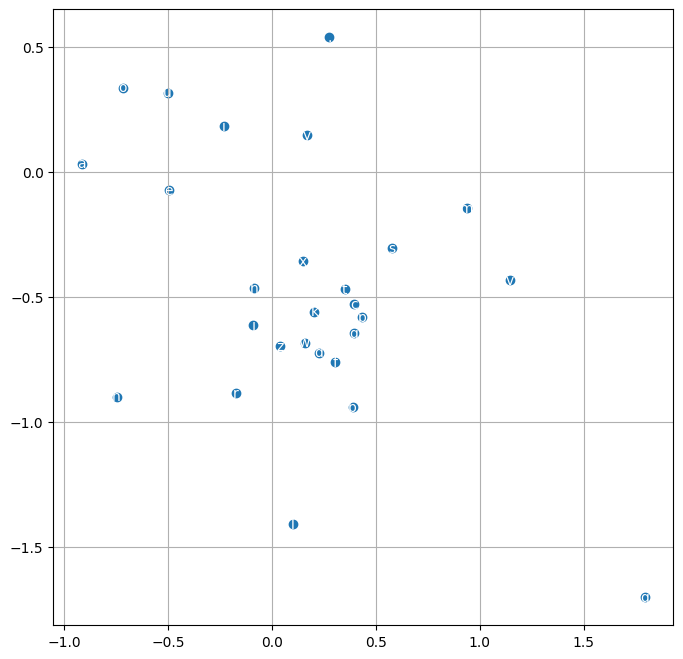

In [79]:
plt.figure(figsize=(8,8))
i=0
C1 = C.cpu().detach().numpy()
plt.scatter(C1[:,0],C1[:,1])
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')